In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
train = pd.read_csv('../input/titanic/train.csv')
test_x = pd.read_csv('../input/titanic/test.csv')
sub = pd.read_csv('../input/titanic/gender_submission.csv')
df = pd.concat([train,test_x], sort = False)  

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## カテゴリ変数の変換

In [3]:
CabinFill = df[df['Cabin'].notnull()]
CabinNull = df[df['Cabin'].isnull()]
CabinFill['Cabin'] = CabinFill['Cabin'].astype(str).str[0]
df = pd.concat([CabinFill, CabinNull], sort = False).sort_values(['PassengerId'])

df['Sex'] = pd.Categorical(df.Sex).codes
df['Embarked'] = pd.Categorical(df.Embarked).codes
df['Cabin'] = pd.Categorical(df.Cabin).codes

df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

df.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,-1,2,2,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0,2,0
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,-1,2,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,2,2,0
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,-1,2,1,1
5,6,0.0,3,"Moran, Mr. James",1,NaN,0,0,330877,8.4583,-1,1,1,1
6,7,0.0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,4,2,1,1
7,8,0.0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,-1,2,5,0
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,347742,11.1333,-1,2,3,0
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,237736,30.0708,-1,0,2,0


## 欠損値を埋めずにLightGBMへ

In [4]:
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

logloss, accuracy = [],[]
drop_cols = ['Name','PassengerId','Ticket','Survived']

train = df[:len(train)]
train_x = train.drop(drop_cols, axis=1)
train_y = train['Survived']

params = {'objective': 'binary', 'seed': 71, 'verbose': 0, 'metrics': 'binary_logloss'}
num_round = 100
categorical_features = ['Pclass', 'Cabin', 'Embarked', 'Sex']

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=71) ### 層化抽出によるクロスバリデーション
for tr_idx, va_idx in kf.split(train_x, train_y):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    lgb_train = lgb.Dataset(tr_x, tr_y)
    lgb_eval = lgb.Dataset(va_x, va_y)
    
    model = lgb.train(params, lgb_train, num_boost_round=num_round,
                     categorical_feature=categorical_features,
                     valid_names=['train', 'valid'], valid_sets=[lgb_train, lgb_eval],
                     early_stopping_rounds=20)
    
    va_pred = model.predict(va_x, num_iteration=model.best_iteration) ### 最適な回数でiterationをストップ
    logloss.append(log_loss(va_y, va_pred)) ### pred が連続値の状態でloglossを追加
    
    va_pred = (va_pred > 0.5).astype(int) ### pred を0か1へ分類
    accuracy.append(accuracy_score(va_y, va_pred)) ### accuracy を算出

print(np.mean(logloss))
print(np.mean(accuracy))

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Cabin', 'Embarked', 'Pclass', 'Sex']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Cabin', 'Embarked', 'Pclass', 'Sex']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Cabin', 'Embarked', 'Pclass', 'Sex']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	train's binary_logloss: 0.618619	valid's binary_logloss: 0.624945
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.58034	valid's binary_logloss: 0.592901
[3]	train's binary_logloss: 0.548696	valid's binary_logloss: 0.567297
[4]	train's binary_logloss: 0.52071	valid's binary_logloss: 0.545282
[5]	train's binary_logloss: 0.497849	valid's binary_logloss: 0.527392
[6]	train's binary_logloss: 0.477158	valid's binary_logloss: 0.511236
[7]	train's binary_logloss: 0.459237	valid's binary_logloss: 0.498356
[8]	train's binary_logloss: 0.443657	valid's binary_logloss: 0.488979
[9]	train's binary_logloss: 0.430022	valid's binary_logloss: 0.480312
[10]	train's binary_logloss: 0.418849	valid's binary_logloss: 0.472005
[11]	train's binary_logloss: 0.407578	valid's binary_logloss: 0.46578
[12]	train's binary_logloss: 0.39673	valid's binary_logloss: 0.458114
[13]	train's binary_logloss: 0.387274	valid's binary_logloss: 0.451791
[14]	train's binary_logloss: 

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Cabin', 'Embarked', 'Pclass', 'Sex']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


## 欠損値を埋める

In [5]:
df.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin            0
Embarked         0
FamilySize       0
IsAlone          0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d4d5143d0>,
      dtype=object)

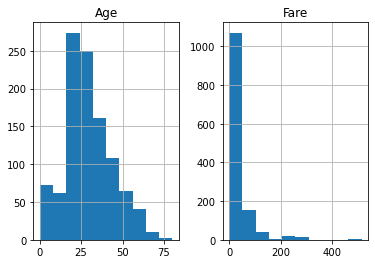

In [6]:
df[['Age', 'Fare']].hist()

In [7]:
df['Age'].fillna((df['Age']).median(), inplace=True)
df['Fare'].fillna((df['Fare']).median(), inplace=True)
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,-1,2,2,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0,2,0
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,-1,2,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,2,2,0
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,-1,2,1,1
5,6,0.0,3,"Moran, Mr. James",1,28.0,0,0,330877,8.4583,-1,1,1,1
6,7,0.0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,4,2,1,1
7,8,0.0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,-1,2,5,0
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,347742,11.1333,-1,2,3,0
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,237736,30.0708,-1,0,2,0


In [8]:
logloss, accuracy, y_preds = [],[],[]
cv_train = np.zeros((len(train),))
drop_cols = ['Name','PassengerId','Ticket','Survived']

train = df[:len(train)]
train_x = train.drop(drop_cols, axis=1)
train_y = train['Survived']

test = df[len(train):]
test_x = test.drop(drop_cols, axis=1)

params = {'objective': 'binary', 'seed': 71, 'verbose': 0, 'metrics': 'binary_logloss'}
num_round = 100
categorical_features = ['Pclass', 'Cabin', 'Embarked', 'Sex']

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train_x, train_y):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    lgb_train = lgb.Dataset(tr_x, tr_y)
    lgb_eval = lgb.Dataset(va_x, va_y)
    
    model = lgb.train(params, lgb_train, num_boost_round=num_round,
                     categorical_feature=categorical_features,
                     valid_names=['train', 'valid'], valid_sets=[lgb_train, lgb_eval],
                     early_stopping_rounds=20)
    
    va_pred = model.predict(va_x, num_iteration=model.best_iteration)
    cv_train[va_idx] = va_pred
    logloss.append(log_loss(va_y, va_pred))
    
    va_pred = (va_pred > 0.5).astype(int)
    accuracy.append(accuracy_score(va_y, va_pred))
    
    y_pred = model.predict(test_x, num_iteration=model.best_iteration) ### test_x に対し逐次的に予測を行う
    
    y_preds.append(y_pred)
    
print(np.mean(logloss))
print(np.mean(accuracy))

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Cabin', 'Embarked', 'Pclass', 'Sex']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Cabin', 'Embarked', 'Pclass', 'Sex']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Cabin', 'Embarked', 'Pclass', 'Sex']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	train's binary_logloss: 0.618588	valid's binary_logloss: 0.625215
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.580162	valid's binary_logloss: 0.593495
[3]	train's binary_logloss: 0.547842	valid's binary_logloss: 0.567667
[4]	train's binary_logloss: 0.520183	valid's binary_logloss: 0.545319
[5]	train's binary_logloss: 0.497003	valid's binary_logloss: 0.527055
[6]	train's binary_logloss: 0.476944	valid's binary_logloss: 0.512505
[7]	train's binary_logloss: 0.459617	valid's binary_logloss: 0.497733
[8]	train's binary_logloss: 0.444052	valid's binary_logloss: 0.486699
[9]	train's binary_logloss: 0.431031	valid's binary_logloss: 0.477701
[10]	train's binary_logloss: 0.419433	valid's binary_logloss: 0.469363
[11]	train's binary_logloss: 0.40749	valid's binary_logloss: 0.458945
[12]	train's binary_logloss: 0.397513	valid's binary_logloss: 0.452228
[13]	train's binary_logloss: 0.388371	valid's binary_logloss: 0.445417
[14]	train's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Cabin', 'Embarked', 'Pclass', 'Sex']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [9]:
y_pred_cv = (cv_train > 0.5).astype(int)
accuracy_score(train_y, y_pred_cv) ### 学習に用いたデータ全体で評価した場合のaccuracy

0.8249158249158249

## ランダムフォレストで feature_importance を出す

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

drop_cols = ['Name','PassengerId','Ticket','Survived']

train = df[:len(train)]
X = train.drop(drop_cols, axis=1)
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
fti = model.feature_importances_ 

print(accuracy)
print('Feature Importances:')
for i, feat in enumerate(X.columns.values):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

0.8100558659217877
Feature Importances:
	Pclass               : 0.070292
	Sex                  : 0.243209
	Age                  : 0.252361
	SibSp                : 0.025163
	Parch                : 0.025506
	Fare                 : 0.235570
	Cabin                : 0.060051
	Embarked             : 0.034158
	FamilySize           : 0.043936
	IsAlone              : 0.009754


In [11]:
drop_cols = ['Name','PassengerId','Ticket','Survived']
test = df[len(train):]
test_x = test.drop(drop_cols, axis=1)

sub_y_RF = model.predict(test_x)
sub['sub_y_RF'] = sub_y_RF

## 変数 Name から敬称・姓を取り出して One-Hot Encoding

In [12]:
df['Title'] = df['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
df['Sur'] = df['Name'].map(lambda name: name.split(',')[0])

df['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Don               1
Capt              1
Jonkheer          1
Mme               1
Sir               1
the Countess      1
Dona              1
Name: Title, dtype: int64

In [13]:
titles_dummies = pd.get_dummies(df['Title'], prefix='Title')
sur_dummies = pd.get_dummies(df['Sur'], prefix='Sur')
df = pd.concat([df, titles_dummies, sur_dummies], axis=1)
df.drop(['Title', 'Sur'], axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Sur_Zabour,Sur_Zakarian,Sur_Zimmerman,Sur_de Brito,Sur_de Messemaeker,Sur_de Mulder,Sur_de Pelsmaeker,Sur_del Carlo,Sur_van Billiard,Sur_van Melkebeke
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,0,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,0,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,0,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,0,0,0,0,0,0,0,0,0,0
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,0,0,0


## LightGBM

In [14]:
logloss, accuracy, y_preds = [],[],[]
cv_train = np.zeros((len(train),))
drop_cols = ['Name','PassengerId','Ticket','Survived','Fare','Cabin','Embarked',
            'Age','SibSp','Parch']

train = df[:len(train)]
train_x = train.drop(drop_cols, axis=1)
train_y = train['Survived']

test = df[len(train):]
test_x = test.drop(drop_cols, axis=1)

params = {'objective': 'binary', 'seed': 71, 'verbose': 0, 'metrics': 'binary_logloss'}
num_round = 100
categorical_features = []

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train_x, train_y):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    lgb_train = lgb.Dataset(tr_x, tr_y)
    lgb_eval = lgb.Dataset(va_x, va_y)
    
    model = lgb.train(params, lgb_train, num_boost_round=num_round,
                     categorical_feature=categorical_features,
                     valid_names=['train', 'valid'], valid_sets=[lgb_train, lgb_eval],
                     early_stopping_rounds=20)
    
    va_pred = model.predict(va_x, num_iteration=model.best_iteration)
    cv_train[va_idx] = va_pred
    logloss.append(log_loss(va_y, va_pred))
    
    va_pred = (va_pred > 0.5).astype(int)
    accuracy.append(accuracy_score(va_y, va_pred))
    
    y_pred = model.predict(test_x, num_iteration=model.best_iteration) ### test_x に対し逐次的に予測を行う
    
    y_preds.append(y_pred)
    
print(np.mean(logloss))
print(np.mean(accuracy))

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	train's binary_logloss: 0.622137	valid's binary_logloss: 0.623862
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.586839	valid's binary_logloss: 0.591025
[3]	train's binary_logloss: 0.55796	valid's binary_logloss: 0.564224
[4]	train's binary_logloss: 0.534123	valid's binary_logloss: 0.542
[5]	train's binary_logloss: 0.514264	valid's binary_logloss: 0.523409
[6]	train's binary_logloss: 0.497609	valid's binary_logloss: 0.507757
[7]	train's binary_logloss: 0.483604	valid's binary_logloss: 0.494381
[8]	train's binary_logloss: 0.4717	valid's binary_logloss: 0.482839
[9]	train's binary_logloss: 0.461635	valid's binary_logloss: 0.473177
[10]	train's binary_logloss: 0.453037	valid's binary_logloss: 0.464775
[11]	train's binary_logloss: 0.445745	valid's binary_logloss: 0.457754
[12]	train's binary_logloss: 0.43945	valid's binary_logloss: 0.451424
[13]	train's binary_logloss: 0.434139	valid's binary_logloss: 0.446283
[14]	train's binary_logloss: 0.4

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[14]	train's binary_logloss: 0.440385	valid's binary_logloss: 0.406576
[15]	train's binary_logloss: 0.435999	valid's binary_logloss: 0.402386
[16]	train's binary_logloss: 0.432626	valid's binary_logloss: 0.398271
[17]	train's binary_logloss: 0.429284	valid's binary_logloss: 0.395331
[18]	train's binary_logloss: 0.426674	valid's binary_logloss: 0.39238
[19]	train's binary_logloss: 0.424116	valid's binary_logloss: 0.39039
[20]	train's binary_logloss: 0.422226	valid's binary_logloss: 0.38832
[21]	train's binary_logloss: 0.4198	valid's binary_logloss: 0.3854
[22]	train's binary_logloss: 0.417735	valid's binary_logloss: 0.382997
[23]	train's binary_logloss: 0.415992	valid's binary_logloss: 0.381233
[24]	train's binary_logloss: 0.414502	valid's binary_logloss: 0.379832
[25]	train's binary_logloss: 0.412764	valid's binary_logloss: 0.378333
[26]	train's binary_logloss: 0.411246	valid's binary_logloss: 0.37698
[27]	train's binary_logloss: 0.410154	valid's binary_logloss: 0.376331
[28]	train's b

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[24]	train's binary_logloss: 0.406935	valid's binary_logloss: 0.402729
[25]	train's binary_logloss: 0.405441	valid's binary_logloss: 0.40191
[26]	train's binary_logloss: 0.404191	valid's binary_logloss: 0.402068
[27]	train's binary_logloss: 0.402402	valid's binary_logloss: 0.401365
[28]	train's binary_logloss: 0.400875	valid's binary_logloss: 0.400931
[29]	train's binary_logloss: 0.399967	valid's binary_logloss: 0.401525
[30]	train's binary_logloss: 0.39872	valid's binary_logloss: 0.401406
[31]	train's binary_logloss: 0.398	valid's binary_logloss: 0.402092
[32]	train's binary_logloss: 0.396968	valid's binary_logloss: 0.40221
[33]	train's binary_logloss: 0.396406	valid's binary_logloss: 0.403154
[34]	train's binary_logloss: 0.395536	valid's binary_logloss: 0.403453
[35]	train's binary_logloss: 0.395	valid's binary_logloss: 0.40426
[36]	train's binary_logloss: 0.394256	valid's binary_logloss: 0.404725
[37]	train's binary_logloss: 0.393804	valid's binary_logloss: 0.405599
[38]	train's bin

In [15]:
y_pred_cv = (cv_train > 0.5).astype(int)
accuracy_score(train_y, y_pred_cv) ### 学習に用いたデータ全体で評価した場合のaccuracy

0.8294051627384961

In [16]:
sub_y_lgb = sum(y_preds) / len(y_preds) 
sub_y_lgb = (sub_y_lgb > 0.5).astype(int)
sub['sub_y_lgb'] = sub_y_lgb

## ロジスティック回帰

In [17]:
from sklearn.linear_model import LogisticRegression
accuracy, y_preds_LR = [],[]
cv_train = np.zeros((len(train),))
drop_cols = ['Name','PassengerId','Ticket','Survived','Fare','Cabin','Embarked',
            'Age','SibSp','Parch']

train = df[:len(train)]
train_x = train.drop(drop_cols, axis=1)
train_y = train['Survived']

test = df[len(train):]
test_x = test.drop(drop_cols, axis=1)


kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train_x, train_y):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    
    model = LogisticRegression(penalty='l2', solver='sag', random_state=0)
    model.fit(tr_x, tr_y)
    
    va_pred = model.predict(va_x)
    cv_train[va_idx] = va_pred
    
    va_pred = (va_pred > 0.5).astype(int)
    accuracy.append(accuracy_score(va_y, va_pred))
    
    y_pred = model.predict(test_x) ### test_x に対し逐次的に予測を行う
    
    y_preds_LR.append(y_pred)
    
print(np.mean(accuracy))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.8327980446814528


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [18]:
sub_y_LR = sum(y_preds_LR) / len(y_preds_LR) 
sub_y_LR = (sub_y_LR > 0.5).astype(int)
sub['sub_y_LR'] = sub_y_LR

## ニューラルネット

In [19]:
import tensorflow as tf # neural networks
from keras.wrappers.scikit_learn import KerasClassifier # neural networks
from keras.models import Sequential  # neural networks
from keras.layers import Dense, Activation, Dropout  # neural networks# dummies
from numpy.random import seed # setting random seeds

drop_cols = ['Name','PassengerId','Ticket','Survived','Fare','Cabin','Embarked',
            'Age','SibSp','Parch']
x_NN = df.drop(drop_cols, axis=1)
# splitting
X_dummies_train = x_NN.iloc[0:890]
X_dummies_test = x_NN.iloc[891:]

# creating labels column
Y = df.iloc[0:890]["Survived"]

In [20]:
def create_neural_net(in_shape, lyrs=[4], act='relu', opt='Adam', dr=0.0):
    # set random seed for reproducibility
    seed(37556)
    tf.random.set_seed(37556)
    
    # initialize the model object
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=in_shape, activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [21]:
single_net = create_neural_net(X_dummies_train.shape[1], lyrs =[4])
single_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 3592      
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 3,597
Trainable params: 3,597
Non-trainable params: 0
_________________________________________________________________


In [22]:
training = single_net.fit(X_dummies_train, Y, epochs=100, batch_size=32,
                         validation_split=0.25, verbose=0)
# outputting the validation accuracy
val_acc = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 81.60%


In [23]:
# initializing the mdoel using best selected hyper-parameters
nn = KerasClassifier(build_fn=create_neural_net, 
                        in_shape = X_dummies_train.shape[1],
                        lyrs=[12, 8, 4], epochs=50, dr=0.1, batch_size=1, 
                         verbose=0)
# fitting to entire training set
nn.fit(X_dummies_train, Y)
# predicting the entire test set
sub['sub_y_NN'] = nn.predict(X_dummies_test).astype('int32')

## アンサンブル

In [24]:
### test_x に対す各foldでの予測値が格納された y_preds について、その平均を最終的な予測値とする
model_cols = ['sub_y_lgb','sub_y_RF','sub_y_NN','sub_y_LR']
sub['Survived'] = np.sum(sub[model_cols], axis=1)
sub['Survived'] = (sub['Survived'] >= 3).astype(int)
sub.drop(model_cols, axis=1, inplace=True)
sub.to_csv('sub_title_ensembled.csv', index=False)
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
